# Keras to Tensorflow Model

In [1]:
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
np.random.seed(0)
import segmentation_models as sm
import sys
import os
sys.path.append("..")
from seg_net.data import *
from seg_net.fast_scnn import fast_scnn

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Architecture

In [3]:
INPUT_SHAPE =  (512,512,3) #(768,768,3) (512,512,3) (256,256,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'Linknet'
LOSS_METRICS = 'BCE_ACC_IOU'
ACTIVATION = 'sigmoid'
DATASET = "train_matte"
IMGNORM = 'divide'

MODEL_PATH_ = '../results/Models/Models'
MODEL_PATH = '../results/Models/GraphModels'

# Output protocol buffer model path
model_fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                IMGNORM,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0],
                                                DATASET)

keras_filename = '{}.hdf5'.format(model_fname)
pb_filename = '{}.pb'.format(model_fname)
pb_op_filename = '{}_op.pb'.format(model_fname)
mlmodel_filename = '{}.mlmodel'.format(model_fname)
mlmodel_fp16_filename = '{}_fp16.mlmodel'.format(model_fname)
mlmodel_Q_filename = '{}_Q.mlmodel'.format(model_fname)
tflite_filename = '{}.tflite'.format(model_fname)
tflite_Q_filename = '{}_Q.tflite'.format(model_fname)

## Build and Load Model

In [3]:
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/home/avantariml/.local/lib/python3.5/site-packages/segmentation_models/backbones/mobilenetv2.py:273: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [3]:
model = fast_scnn(input_shape = INPUT_SHAPE, 
                  num_classes = NUM_CLASS, 
                  activation = ACTIVATION, 
                  dropout_rate = 0.3,
                  backbone_name = BACKBONE)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model.load_weights(os.path.join(MODEL_PATH_,keras_filename))
print("Loading from ",os.path.join(MODEL_PATH_,keras_filename))

Loading from  ../results/Models/Models/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte.hdf5


In [5]:
model.compile('sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.save(os.path.join(MODEL_PATH_,keras_filename))

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 513, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## save keras model as tf .pb and as CoreML .mlmodel

In [9]:
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference
import coremltools
from seg_net.keras_to_tensorflow import *

In [6]:
input_node_names = [node.op.name for node in model.inputs]
print(input_node_names)

['input_1']


In [7]:
# output_names
output_node_names = [node.op.name for node in model.outputs]
print(output_node_names)

['sigmoid/Sigmoid']


### Freezing the model to .pb

In [10]:
graphDef = freeze_keras(K.get_session(), input_node_names, output_node_names, optimize = False,
                        quantize= False, clear_devices = True)
tf.train.write_graph(graphDef, MODEL_PATH, pb_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Converted 404 variables to const ops.


INFO:tensorflow:Converted 404 variables to const ops.


'../results/Models/GraphModels/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte.pb'

In [11]:
for name in [n.name for n in graphDef.node]:
    print(name)

input_1
Conv1_pad/Pad/paddings
Conv1_pad/Pad
Conv1/kernel
Conv1/kernel/read
Conv1/convolution
trainable
trainable/read
bn_Conv1/gamma
bn_Conv1/gamma/read
bn_Conv1/beta
bn_Conv1/beta/read
bn_Conv1/moving_mean
bn_Conv1/moving_mean/read
bn_Conv1/moving_variance
bn_Conv1/moving_variance/read
bn_Conv1/keras_learning_phase/input
bn_Conv1/keras_learning_phase
bn_Conv1/Cast
bn_Conv1/Const_4
bn_Conv1/Cast_1
bn_Conv1/cond/pred_id
bn_Conv1/cond/Switch_1
bn_Conv1/cond/Switch_2
bn_Conv1/cond/Merge
bn_Conv1/Const_5
bn_Conv1/Const_6
bn_Conv1/FusedBatchNorm
bn_Conv1/Cast_3
bn_Conv1/cond_1/pred_id
bn_Conv1/cond_1/Switch_1
bn_Conv1/cond_1/FusedBatchNorm
bn_Conv1/cond_1/FusedBatchNorm/Switch
bn_Conv1/cond_1/FusedBatchNorm/Switch_1
bn_Conv1/cond_1/FusedBatchNorm/Switch_2
bn_Conv1/cond_1/FusedBatchNorm/Switch_3
bn_Conv1/cond_1/FusedBatchNorm/Switch_4
bn_Conv1/cond_1/Merge
Conv1_relu/Relu6
expanded_conv_depthwise/depthwise_kernel
expanded_conv_depthwise/depthwise_kernel/read
expanded_conv_depthwise/depthwis

In [13]:
#sess.run(tf.global_variables_initializer())
graphDef = K.get_session().graph.as_graph_def()
output_node_names_gv = output_node_names + [v.op.name for v in tf.global_variables()]
graphDef = optimize_for_inference(graphDef,
                                   input_node_names,
                                   output_node_names_gv,
                                   tf.float32.as_datatype_enum,
                                   toco_compatible=True)
tf.train.write_graph(graphDef, MODEL_PATH, pb_op_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 16
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 16
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 32
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 32
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 64
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 64
      }
      dim {
        size: 384
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 384
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 160
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 160
      }
      dim {
        size: 960
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 960
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 1280
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 1280
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 1280
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 1280
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 320
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 320
      }
      dim {
        size: 320
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 320
      }
      dim {
        size: 576
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 576
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 144
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 144
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 192
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 48
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 192
      }
      dim {
        size: 48
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 48
      }
      dim {
        size: 48
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 48
      }
      dim {
        size: 48
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 48
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 48
      }
      dim {
        size: 144
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 36
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 144
      }
      dim {
        size: 36
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 36
      }
      dim {
        size: 36
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 36
      }
      dim {
        size: 36
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 36
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 36
      }
      dim {
        size: 96
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 96
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 24
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 3
      }
      dim {
        size: 3
      }
      dim {
        size: 24
      }
      dim {
        size: 24
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


op: "VariableV2"
attr {
  key: "container"
  value {
    s: ""
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 1
      }
      dim {
        size: 24
      }
      dim {
        size: 16
      }
    }
  }
}
attr {
  key: "shared_name"
  value {
    s: ""
  }
}
 instead. Maybe because freeze_graph wasn't run first?


'../results/Models/GraphModels/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte_op.pb'

### keras to .tflite

In [27]:
tf.keras.losses.custom_loss = sm.losses.bce_dice_loss

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Froze 337 variables.


INFO:tensorflow:Froze 337 variables.


INFO:tensorflow:Converted 337 variables to const ops.


INFO:tensorflow:Converted 337 variables to const ops.


In [12]:
converter_Q = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))
converter_Q.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
converter_Q.post_training_quantize=True
tflite_Q_model = converter_Q.convert()
with open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:
    f.write(tflite_Q_model)

INFO:tensorflow:Froze 337 variables.


INFO:tensorflow:Froze 337 variables.


INFO:tensorflow:Converted 337 variables to const ops.


INFO:tensorflow:Converted 337 variables to const ops.


In [38]:
# Converting a tf.keras model.
converter = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Converted 404 variables to const ops.


INFO:tensorflow:Converted 404 variables to const ops.


ConverterError: TOCO failed. See console for info.
2019-05-23 12:51:19.589630: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 2173 operators, 3475 arrays (0 quantized)
2019-05-23 12:51:19.670897: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 2173 operators, 3475 arrays (0 quantized)
2019-05-23 12:51:19.671821: F tensorflow/lite/toco/graph_transformations/resolve_constant_unary.cc:234] Unsupported cast op input type
Aborted (core dumped)




In [11]:
# Converting a tf.keras model.
converter_Q = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
converter_Q.post_training_quantize=True
tflite_Q_model = converter_Q.convert()
with open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:
    f.write(tflite_Q_model)

INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Froze 404 variables.


INFO:tensorflow:Converted 404 variables to const ops.


INFO:tensorflow:Converted 404 variables to const ops.


ConverterError: TOCO failed. See console for info.
2019-05-23 10:05:58.309350: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 2173 operators, 3475 arrays (0 quantized)
2019-05-23 10:05:58.392009: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 2173 operators, 3475 arrays (0 quantized)
2019-05-23 10:05:58.392686: F tensorflow/lite/toco/graph_transformations/resolve_constant_unary.cc:234] Unsupported cast op input type
Aborted (core dumped)




### keras to .mlmodel

In [15]:
def convert_lambda(layer):
    
    import keras.backend as K
    # Only convert this Lambda layer if it is for our tf image resize function.
    if layer.function == K.tf.image.resize_images:

        from coremltools.proto import NeuralNetwork_pb2

        params = NeuralNetwork_pb2.CustomLayerParams()

        # The name of the Swift or Obj-C class that implements this layer.
        params.className = "Resize"

        # The desciption is shown in Xcode's mlmodel viewer.
        params.description = "A resize function"

        return params
    else:
        return None
    
coreml_model = coremltools.converters.keras.convert(model,
                                                    input_names=input_node_names,
                                                    image_input_names=input_node_names,
                                                    output_names=output_node_names,
                                                    image_scale=1/255.0,
                                                    add_custom_layers=True,
                                                    custom_conversion_functions={ "Lambda": convert_lambda }
                                                   )

0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7f8b48555ac8>
1 : Conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7f8b4855a9e8>
2 : Conv1, <keras.layers.convolutional.Conv2D object at 0x7f8b4855a4e0>
3 : bn_Conv1, <keras.layers.normalization.BatchNormalization object at 0x7f8aa06ce748>
4 : Conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f8aa06ce5f8>
5 : expanded_conv_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7f8a9f42e6a0>
6 : expanded_conv_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7f8a9c3e7c50>
7 : expanded_conv_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7f8a9c34c7b8>
8 : expanded_conv_project, <keras.layers.convolutional.Conv2D object at 0x7f8a9c310cc0>
9 : expanded_conv_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7f8a9c27ec18>
10 : block_1_expand, <keras.layers.convolutional.Conv2D object at 0x7f8a9c270c88>
11 : block_1_expand_BN,

93 : block_10_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x7f8a3823def0>
94 : block_10_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7f8a382329e8>
95 : block_10_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7f8a3826ae10>
96 : block_10_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7f8a381646d8>
97 : block_10_project, <keras.layers.convolutional.Conv2D object at 0x7f8a38120b00>
98 : block_10_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7f8a38090240>
99 : block_11_expand, <keras.layers.convolutional.Conv2D object at 0x7f8a207baf98>
100 : block_11_expand_BN, <keras.layers.normalization.BatchNormalization object at 0x7f8a2074db00>
101 : block_11_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x7f8a207682e8>
102 : block_11_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7f8a206a8f60>
103 : block_11_depthwise_BN, <keras.layers.normalization.Bat

186 : decoder_stage2_relu3, <keras.layers.core.Activation object at 0x7f8762855e10>
187 : add_3, <keras.layers.merge.Add object at 0x7f8761dee898>
188 : decoder_stage3_conv1, <keras.layers.convolutional.Conv2D object at 0x7f8761e219e8>
189 : decoder_stage3_bn1, <keras.layers.normalization.BatchNormalization object at 0x7f8761dca240>
190 : decoder_stage3_relu1, <keras.layers.core.Activation object at 0x7f8761d36f98>
191 : decoder_stage3_upsample2, <keras.layers.convolutional.UpSampling2D object at 0x7f8761d084e0>
192 : decoder_stage3_conv2, <keras.layers.convolutional.Conv2D object at 0x7f8761cc4518>
193 : decoder_stage3_bn2, <keras.layers.normalization.BatchNormalization object at 0x7f8761c51208>
194 : decoder_stage3_relu2, <keras.layers.core.Activation object at 0x7f8761befba8>
195 : decoder_stage3_conv3, <keras.layers.convolutional.Conv2D object at 0x7f8761bbeeb8>
196 : decoder_stage3_bn3, <keras.layers.normalization.BatchNormalization object at 0x7f8761b7ec88>
197 : decoder_stage3_r

In [16]:
spec = coreml_model.get_spec()
print(spec.description)

input {
  name: "input_1"
  type {
    imageType {
      width: 512
      height: 512
      colorSpace: RGB
    }
  }
}
output {
  name: "sigmoid/Sigmoid"
  type {
    multiArrayType {
      shape: 1
      shape: 512
      shape: 512
      dataType: DOUBLE
    }
  }
}



In [17]:
coreml_model.save(os.path.join(MODEL_PATH, mlmodel_filename))

In [20]:
model_spec = coremltools.utils.load_spec(os.path.join(MODEL_PATH, mlmodel_filename))
model_fp16_spec = coremltools.utils.convert_neural_network_spec_weights_to_fp16(model_spec)
coremltools.utils.save_spec(model_fp16_spec, os.path.join(MODEL_PATH, mlmodel_fp16_filename))

In [19]:
quantized_coreml_spec = coremltools.models.neural_network.quantization_utils.quantize_weights(coreml_model,8)
coremltools.utils.save_spec(quantized_coreml_spec, os.path.join(MODEL_PATH, mlmodel_Q_filename))

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused Conv1->bn_Conv1
Fused expanded_conv_depthwise->expanded_conv_depthwise_BN
Fused expanded_conv_project->expanded_conv_project_BN
Fused block_1_expand->block_1_expand_BN
Fused block_1_depthwise->block_1_depthwise_BN
Fused block_1_project->block_1_project_BN
Fused block_2_expand->block_2_expand_BN
Fused block_2_depthwise->block_2_depthwise_BN
Fused block_2_project->block_2_project_BN
Fused block_3_expand->block_3_expand_BN
Fused block_3_depthwise->block_3_depthwise_BN
Fused block_3_project->block_3_project_BN
Fused block_4_expand->block_4_expand_BN
Fused block_4_depthwise->block_4_depthwise_BN
Fused block_4_project->block_4_project_BN
Fused block_5_expand->block_5_expand_BN
Fused block_5_depthwise->block_5_depthwise_BN
Fused block_5_project->block_5_project_BN
Fused block_6_expand->block_6_expand_BN
Fused block_6_depthwise->block_6_depthwise_BN
Fused block_6_project->block_6_project_BN
Fused block_7_

## load & inference the model

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import skimage
import glob
import os
import cv2

In [5]:
sess = tf.Session()

In [6]:
# Load Test Images
test_path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(test_path,"*.jpg")))
images = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    images.append(img)

In [7]:
# load model from pb file
#with tf.gfile.GFile(os.path.join(MODEL_PATH,pb_op_filename),'rb') as f:
pb_op_filename = "/media/new_hdd2/seg_net/results/Models/GraphModels/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte_Qotp.pb"
with tf.gfile.GFile(os.path.join(MODEL_PATH,pb_filename),'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    g_in = tf.import_graph_def(graph_def)
print("Loading from ",os.path.join(MODEL_PATH,pb_filename))

Loading from  ../results/Models/GraphModels/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte.pb


CPU times: user 129 ms, sys: 65 ms, total: 194 ms
Wall time: 76.5 ms


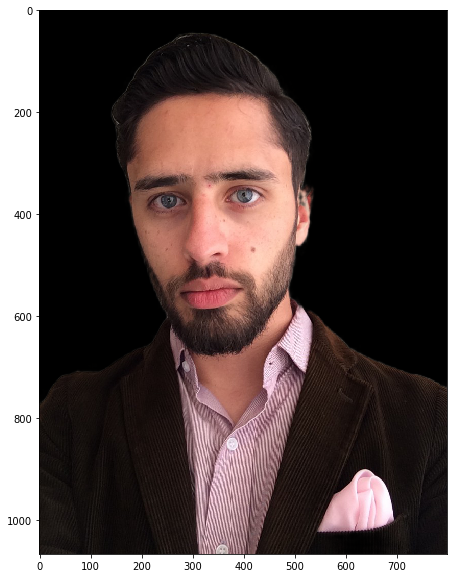

In [24]:
%%time
# Choose a random image and preprocess for inference.
i = random.choice(range(0,len(images)))
img  = images[i]
img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
img_ = preprocess_input(img_, imgNorm=IMGNORM)
# inference by the model (op name must comes with :0 to specify the index of its output)
tensor_output = sess.graph.get_tensor_by_name('import/sigmoid/Sigmoid:0')
tensor_input = sess.graph.get_tensor_by_name('import/input_1:0')
output = sess.run(tensor_output, {tensor_input: img_})
# Resize and Apply Mask on input image.
mask = skimage.transform.resize(np.squeeze(output),img.shape[:2],preserve_range=True)
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), img.astype(float))/255
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)

In [ ]:
sess.close()

### Testing TFLite model using Python API

In [35]:
# Load TFLite model and allocate tensors.
#interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_filename))
interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_Q_filename))
#interpreter = tf.lite.Interpreter(model_path="/media/new_hdd2/seg_net/results/Models/Models/sample_tf.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details[0]['shape']

array([  1, 512, 512,   3], dtype=int32)

CPU times: user 3.47 s, sys: 531 ms, total: 4 s
Wall time: 3.81 s


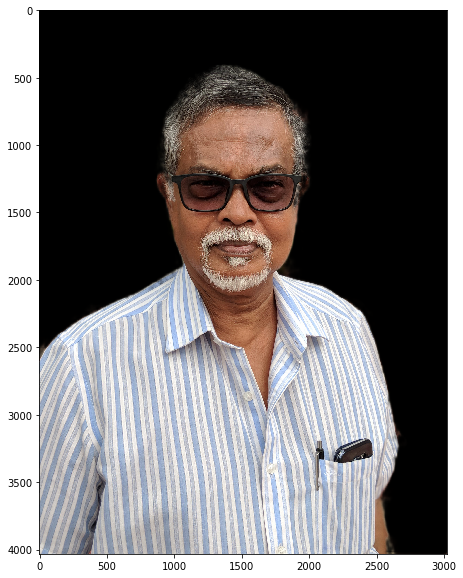

In [37]:
%%time
# Choose a random image and preprocess for inference.
i = random.choice(range(0,len(images)))
img  = images[i]#skimage.io.imread("/home/avantariml/Downloads/IMG_3309.jpg")
img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
#img_ = np.expand_dims(cv2.resize(img,(257, 257)),axis=0)
img_ = preprocess_input(img_, imgNorm="divide")
interpreter.set_tensor(input_details[0]['index'], img_)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
# Resize and Apply Mask on input image.
mask = skimage.transform.resize(np.squeeze(output),img.shape[:2],preserve_range=True)
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), img.astype(float))/255
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)#(np.squeeze(output))